# Classification: Learning Labels of Astronomical Sources
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/brics_astro/blob/main/Week7/02_classification.ipynb)

Modern astronomy is concerned with the study and characterization of distant objects such as stars, galaxies, or quasars. Objects can often be very quickly characterised through measurements of their optical spectrum. A spectrum is a measure of the photon flux as a function of wavelength.

The spectrum of the star Vega $(\alpha-Lyr)$ with the five filters from the Sloan Digital Sky Survey (SDSS), which are denoted by the letters $u$ (ultraviolet), $g$ (green), $r$ (red), $i$ (infrared), and $z$ (infrared).

The above spectrum is that of the star Vega, the brightest star in the northern constellation Lyra. Its surface is at about 9600 degrees Kelvin, and its spectrum is roughly that of a 9600K black-body, with absorption due to molecules in its cooler atmosphere. The deepest of these absorption spikes are due to the energy levels of Hydrogen. From examination of high-resolution spectra like this one, one can learn a lot about the physical processes at work in a distant astronomical source.

Unfortunately, spectra like these are very time-consuming and expensive to obtain, especially for very faint objects. For this reason, astronomers have long observed objects through broad-band filters, recording the observations using the magnitude system. For the u-band filter shown above, the magnitude is defined as

$$ u = m_{ref} - 2.5 \log_{10}\left[
\int_0^\infty F(\lambda) S(\lambda) d\lambda\right]$$

Here F(\lambda) is the filter transmission, and $S(\lambda)$ is the flux at wavelength $\lambda$. The constant $m_{ref}$ encodes the calibration of the telescope. The reason for the logarithmic form of the magnitude is historical.

Astronomers generally work in terms of the color, defined as the difference of magnitudes between two different filter bands. This is because the constant $m_{ref}$ can be difficult to calibrate from telescope to telescope or from night to night. Subtracting two magnitudes reduces this uncertainty. For example, an observation of the star Vega above will consist of a vector four numbers: $[u-g, g-r, r-i, i-z]$.

Because of this, machine-learning tasks in Astronomy are often based on a small spectroscopic training set, with a larger set of photometric observations with unknown labels or classification. We’ll examine a few of those situations here.

**Note:**
If you are running this jupyter notebook from Colab, then run the next cell by pressing `SHIFT+ENTER` to install the required packages for this notebook. Otherwise, skip the next cell.

In [ ]:
!mkdir -p data
!wget -P data https://raw.githubusercontent.com/Danselem/brics_astro/main/Week7/data/sdss_photoz.npy

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [3]:
spec_data = pd.read_csv('data/sdssdr16-class.csv')


spec_data.head()

,objID,RA_ICRS,DE_ICRS,class,umag,gmag,rmag,imag,zmag,spCl,subCl,zph,MJD
0,1237666091131011305,18.495409,27.589361,3,22.462,21.715,20.348,19.596,19.055,GALAXY,NaN,0.4981,53243.4181
1,1237666091131011951,18.491499,27.624925,3,22.326,20.721,19.435,18.952,18.525,GALAXY,NaN,0.2684,53243.4181
2,1237666091131011499,18.460470,27.618517,3,23.190,21.260,19.756,19.212,18.854,GALAXY,NaN,0.2886,53243.4181
3,1237666091131011399,18.528478,27.666562,3,24.028,24.740,21.926,20.415,19.758,GALAXY,NaN,0.9415,53243.4181
4,1237666216223179972,18.356333,27.550240,3,23.089,23.447,21.431,20.212,19.560,GALAXY,NaN,0.6508,53263.3909


In [4]:
spec_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   objID    300000 non-null  int64  
 1   RA_ICRS  300000 non-null  float64
 2   DE_ICRS  300000 non-null  float64
 3   class    300000 non-null  int64  
 4   umag     300000 non-null  float64
 5   gmag     300000 non-null  float64
 6   rmag     300000 non-null  float64
 7   imag     299999 non-null  float64
 8   zmag     300000 non-null  float64
 9   spCl     300000 non-null  object 
 10  subCl    175970 non-null  object 
 11  zph      102787 non-null  float64
 12  MJD      300000 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 29.8+ MB


In [5]:
spec_data= spec_data[spec_data['zph'].notna()]

In [6]:
spec_data["spCl"].value_counts()

spCl
GALAXY    90940
QSO        6420
STAR       5427
Name: count, dtype: int64

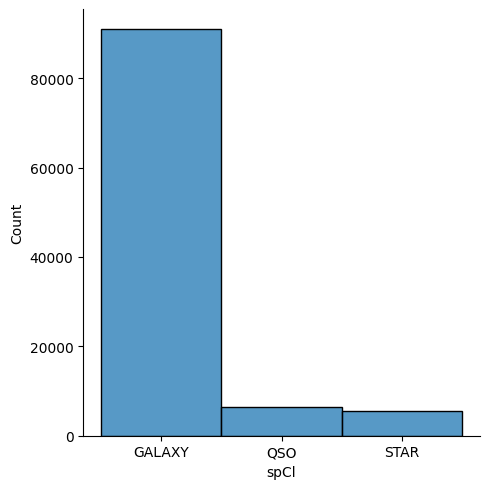

In [7]:
sns.displot(spec_data["spCl"])
plt.show()

In [8]:
spec_data['u-g'] = spec_data['umag'] - spec_data['gmag']
spec_data['g-r'] =spec_data['gmag'] - spec_data['rmag']
spec_data['r-i'] = spec_data['rmag'] - spec_data['imag']
spec_data['i-z'] = spec_data['imag'] - spec_data['zmag']
    


spec_data.head()

,objID,RA_ICRS,DE_ICRS,class,umag,gmag,rmag,imag,zmag,spCl,subCl,zph,MJD,u-g,g-r,r-i,i-z
0,1237666091131011305,18.495409,27.589361,3,22.462,21.715,20.348,19.596,19.055,GALAXY,NaN,0.4981,53243.4181,0.747,1.367,0.752,0.541
1,1237666091131011951,18.491499,27.624925,3,22.326,20.721,19.435,18.952,18.525,GALAXY,NaN,0.2684,53243.4181,1.605,1.286,0.483,0.427
2,1237666091131011499,18.460470,27.618517,3,23.190,21.260,19.756,19.212,18.854,GALAXY,NaN,0.2886,53243.4181,1.930,1.504,0.544,0.358
3,1237666091131011399,18.528478,27.666562,3,24.028,24.740,21.926,20.415,19.758,GALAXY,NaN,0.9415,53243.4181,-0.712,2.814,1.511,0.657
4,1237666216223179972,18.356333,27.550240,3,23.089,23.447,21.431,20.212,19.560,GALAXY,NaN,0.6508,53263.3909,-0.358,2.016,1.219,0.652


In [11]:
label_encoder = LabelEncoder()
spec_data['label'] = label_encoder.fit_transform(spec_data['spCl'])

print("Class Labels:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Labels: {'GALAXY': np.int64(0), 'QSO': np.int64(1), 'STAR': np.int64(2)}


In [12]:
spec_data.describe()

,objID,RA_ICRS,DE_ICRS,class,umag,gmag,rmag,imag,zmag,zph,MJD,u-g,g-r,r-i,i-z,label
count,1.027870e+05,102787.000000,102787.000000,102787.0,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000,102787.000000
mean,1.237671e+18,65.982240,30.648139,3.0,23.197294,21.479907,19.998811,19.146222,18.671220,0.457299,53848.946108,1.717387,1.481095,0.852589,0.475003,0.168056
std,9.991405e+12,57.033327,11.755079,0.0,2.126712,1.938976,1.705442,1.493588,1.427559,0.211821,1213.292794,1.402204,0.583487,0.353042,0.296333,0.495392
min,1.237646e+18,5.304001,0.040779,3.0,11.912000,11.965000,11.066000,10.704000,11.022000,0.000700,51078.414400,-8.483000,-7.211000,-7.057000,-9.383000,0.000000
25%,1.237661e+18,22.679492,23.327295,3.0,22.049000,20.574000,18.961000,18.320500,17.911000,0.314700,52621.430800,0.804000,1.119000,0.590000,0.349000,0.000000
50%,1.237679e+18,29.845435,30.763930,3.0,23.264000,21.947000,20.422000,19.481000,19.006000,0.495100,54742.341100,1.684000,1.540000,0.862000,0.443000,0.000000
75%,1.237680e+18,139.780916,40.657703,3.0,24.741000,22.754000,21.276500,20.174000,19.597000,0.597400,54857.191500,2.453000,1.795000,1.093000,0.620000,0.000000
max,1.237681e+18,179.990754,84.380505,3.0,29.712000,28.927000,30.334000,24.952000,25.822000,1.000000,55152.319500,11.624000,8.122000,8.878000,6.598000,2.000000


In [13]:
spec_data['label'] = spec_data['label'].astype('Int64')
spec_data.label.value_counts()

label
0    90940
1     6420
2     5427
Name: count, dtype: Int64

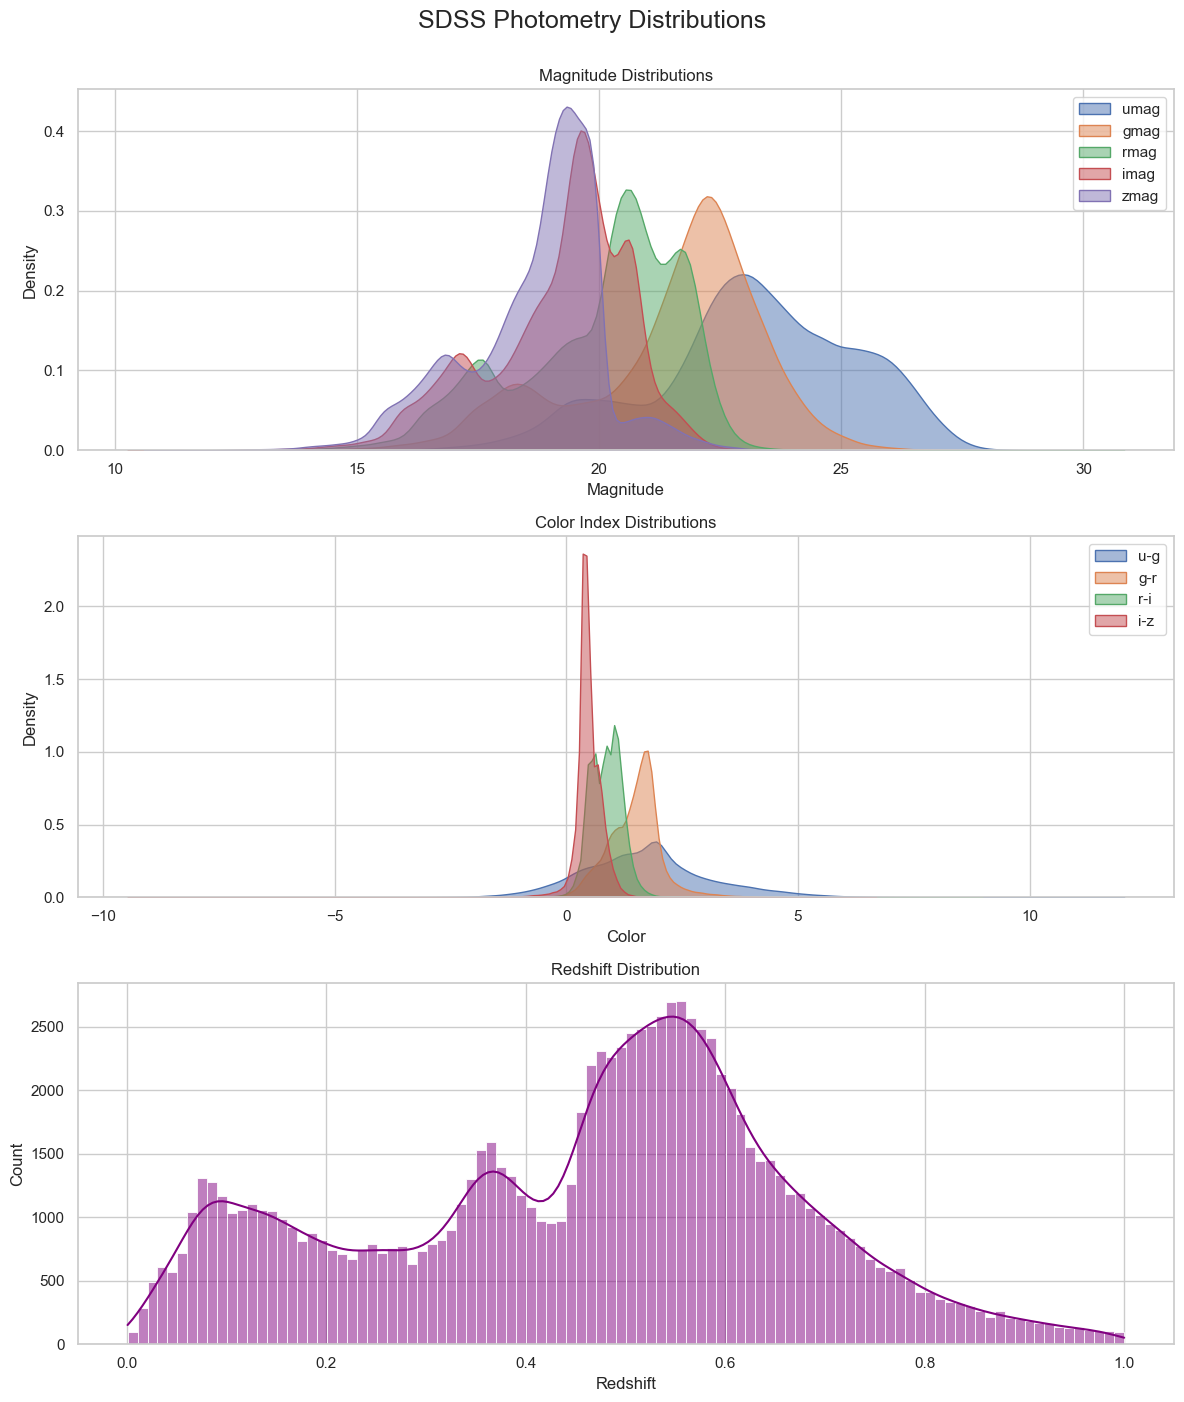

In [14]:
# Set Seaborn theme
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('SDSS Photometry Distributions', fontsize=18, y=1)

# 1. Magnitudes
mags = ['umag', 'gmag', 'rmag', 'imag', 'zmag']
for mag in mags:
    sns.kdeplot(spec_data[mag], label=mag, ax=axes[0], fill=True, alpha=0.5)
axes[0].set_title('Magnitude Distributions')
axes[0].set_xlabel('Magnitude')
axes[0].legend()

# 2. Colors
colors = ['u-g', 'g-r', 'r-i', 'i-z']
for color in colors:
    sns.kdeplot(spec_data[color], label=color, ax=axes[1], fill=True, alpha=0.5)
axes[1].set_title('Color Index Distributions')
axes[1].set_xlabel('Color')
axes[1].legend()

# 3. Redshift
sns.histplot(spec_data['zph'], bins=100, kde=True, ax=axes[2], color='purple')
axes[2].set_title('Redshift Distribution')
axes[2].set_xlabel('Redshift')

plt.tight_layout()
plt.show()


In [15]:
features= ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'u-g', 'g-r', 'r-i', 'i-z', 'zph']
label = 'label'

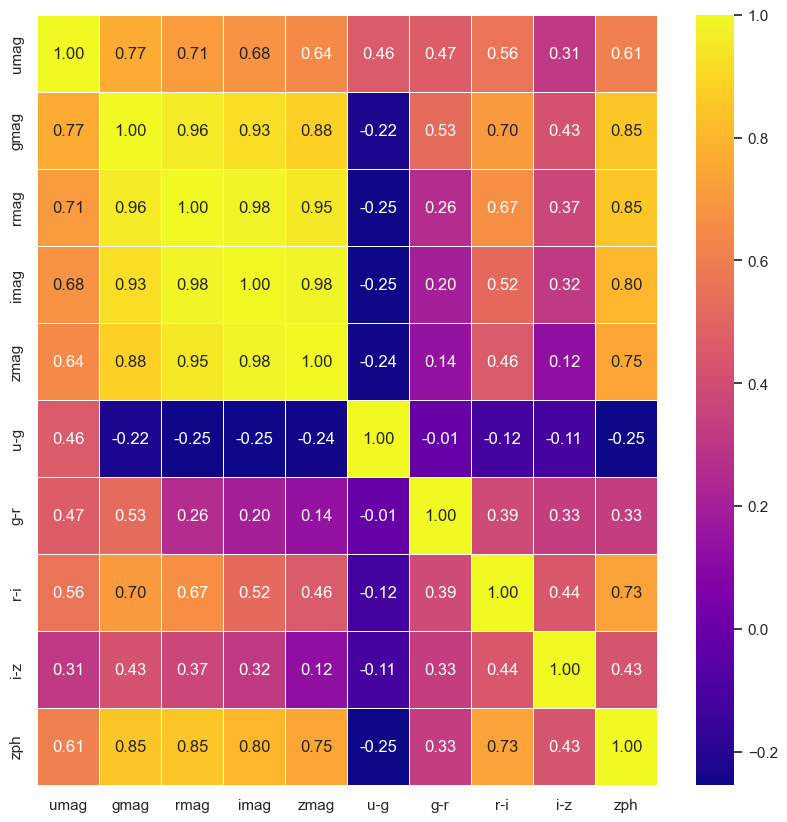

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(spec_data[features].corr(), annot = True, fmt = ".2f", linewidths = .5, cmap='plasma')
plt.show()

In [21]:
X = spec_data[features]
y = spec_data[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [22]:
X_train

,umag,gmag,rmag,imag,zmag,u-g,g-r,r-i,i-z,zph
7908,20.742,18.846,17.837,17.393,17.056,1.896,1.009,0.444,0.337,0.1172
97485,22.989,22.279,20.444,19.510,18.979,0.710,1.835,0.934,0.531,0.5250
74797,23.437,24.259,22.282,20.906,19.954,-0.822,1.977,1.376,0.952,0.9066
58686,23.317,22.482,20.926,19.952,19.491,0.835,1.556,0.974,0.461,0.5310
13897,26.118,23.934,22.596,21.024,19.932,2.184,1.338,1.572,1.092,0.5736
...,...,...,...,...,...,...,...,...,...,...
80098,25.014,20.714,18.955,18.192,17.606,4.300,1.759,0.763,0.586,0.4171
90700,22.068,21.229,19.549,18.814,18.280,0.839,1.680,0.735,0.534,0.4329
49451,22.652,22.857,21.215,20.158,19.691,-0.205,1.642,1.057,0.467,0.5797
76785,22.670,20.564,18.791,18.178,17.736,2.106,1.773,0.613,0.442,0.3651


In [23]:
def evaluate_pipeline(model, name, X, y, feature_names=None, cv=5):
    print(f"\n{name}")
    print("-" * len(name))

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Cross-validated predictions and probabilities
    y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
    pipeline.fit(X, y)
    
    print(f"Accuracy (CV): {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(y, y_pred, average='weighted'):.4f}")
    print(f"F1 Score:  {f1_score(y, y_pred, average='weighted'):.4f}")

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} — Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Feature importances for tree-based models
    if hasattr(model, "feature_importances_") and feature_names is not None:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
        plt.title(f"{name} — Feature Importance")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    # Multiclass ROC AUC
    if hasattr(model, "predict_proba"):
        y_proba = cross_val_predict(pipeline, X, y, cv=cv, method="predict_proba")
        class_labels = np.unique(y)
        y_bin = label_binarize(y, classes=class_labels)

        roc_auc = roc_auc_score(y_bin, y_proba, average="weighted", multi_class="ovr")
        print(f"Multiclass ROC AUC (OvR, weighted): {roc_auc:.4f}")

        # Plot ROC curves for each class
        fpr = dict()
        tpr = dict()
        roc_auc_dict = dict()

        plt.figure(figsize=(8, 6))
        for i, label in enumerate(class_labels):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc_dict[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc_dict[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{name} — Multiclass ROC Curve')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Random Forest
-------------
Accuracy (CV): 0.8925
Precision: 0.8695
Recall:    0.8925
F1 Score:  0.8721

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     90940
         1.0       0.49      0.20      0.29      6420
         2.0       0.66      0.28      0.39      5427

    accuracy                           0.89    102787
   macro avg       0.69      0.49      0.54    102787
weighted avg       0.87      0.89      0.87    102787



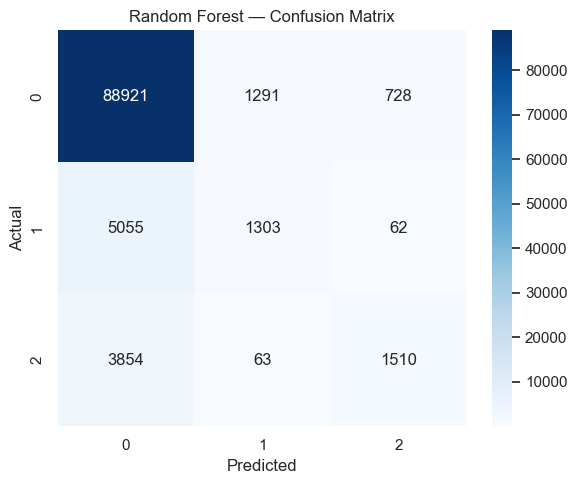

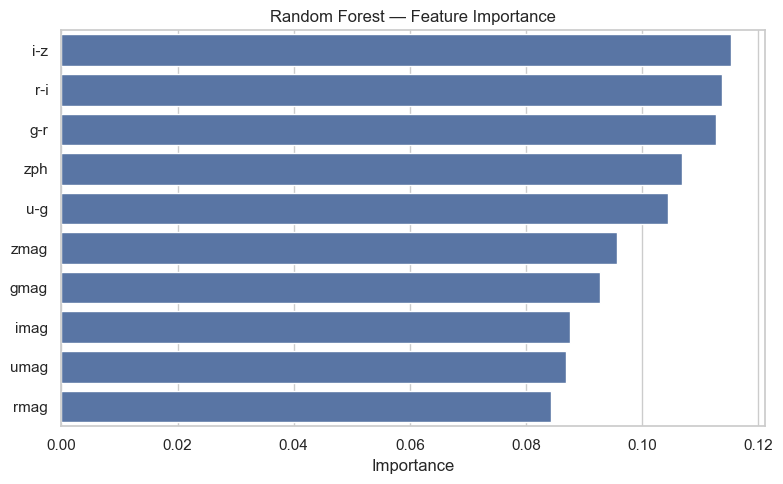

Multiclass ROC AUC (OvR, weighted): 0.8043


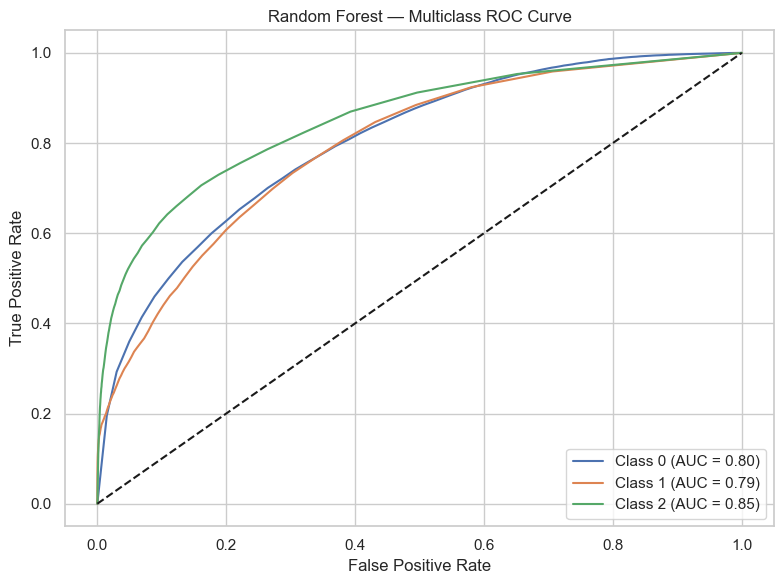


Logistic Regression
-------------------
Accuracy (CV): 0.8799
Precision: 0.8177
Recall:    0.8799
F1 Score:  0.8311

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     90940
         1.0       0.14      0.02      0.03      6420
         2.0       0.48      0.01      0.02      5427

    accuracy                           0.88    102787
   macro avg       0.50      0.34      0.33    102787
weighted avg       0.82      0.88      0.83    102787



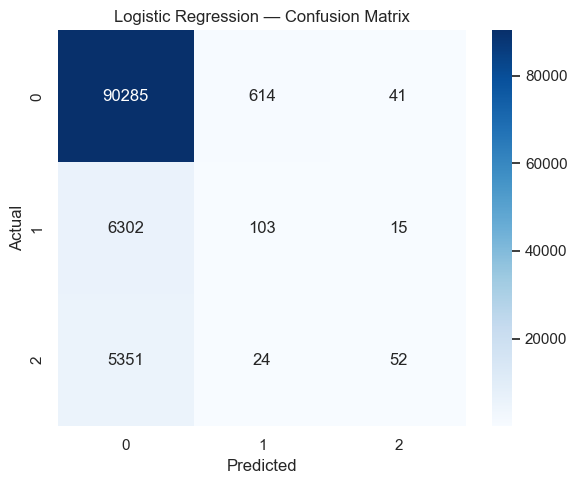

Multiclass ROC AUC (OvR, weighted): 0.6692


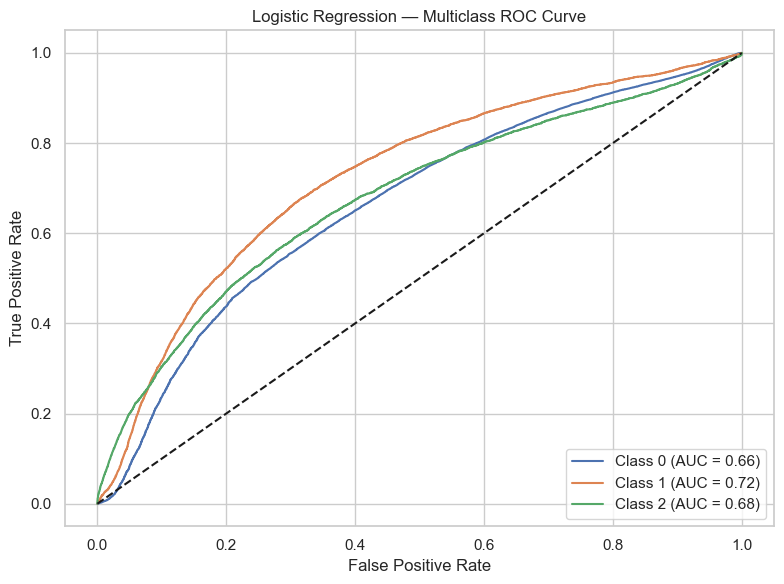


Decision Tree
-------------
Accuracy (CV): 0.8234
Precision: 0.8391
Recall:    0.8234
F1 Score:  0.8308

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     90940
         1.0       0.22      0.28      0.25      6420
         2.0       0.30      0.33      0.31      5427

    accuracy                           0.82    102787
   macro avg       0.48      0.50      0.49    102787
weighted avg       0.84      0.82      0.83    102787



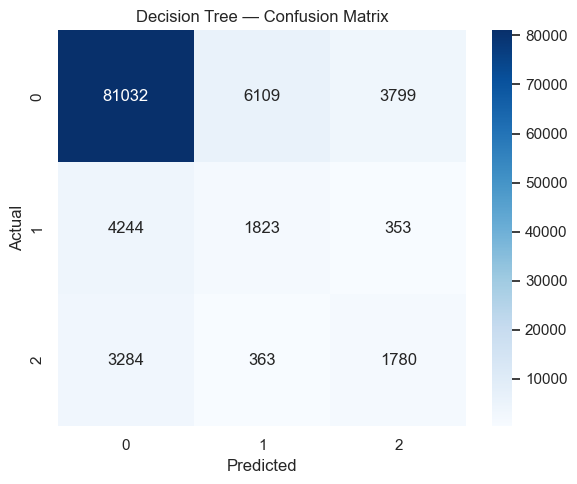

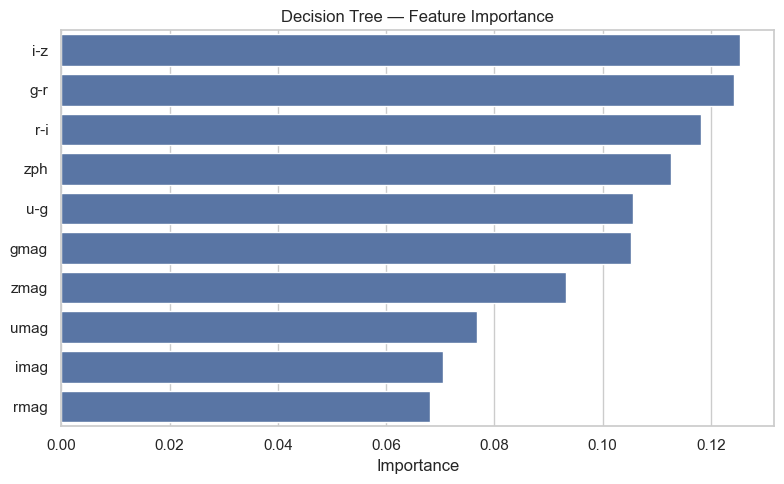

Multiclass ROC AUC (OvR, weighted): 0.6274


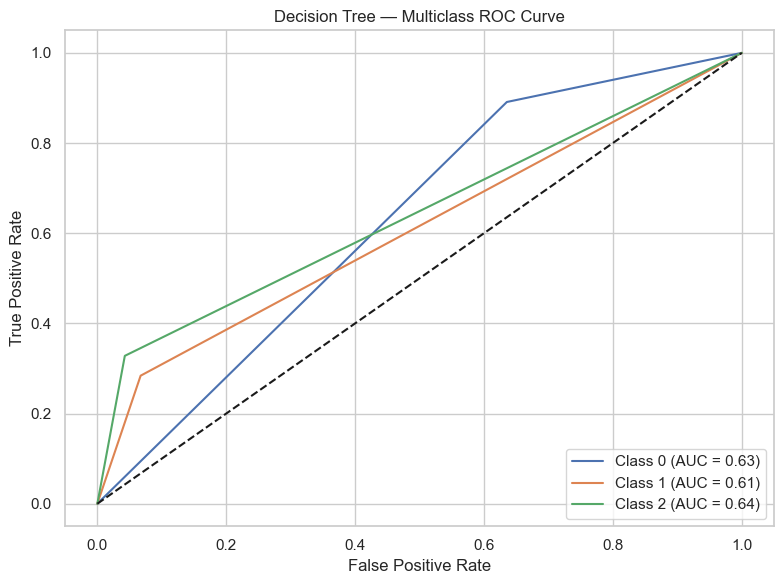


KNN Classifier
--------------
Accuracy (CV): 0.8904
Precision: 0.8664
Recall:    0.8904
F1 Score:  0.8694

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     90940
         1.0       0.48      0.21      0.29      6420
         2.0       0.63      0.24      0.35      5427

    accuracy                           0.89    102787
   macro avg       0.67      0.48      0.53    102787
weighted avg       0.87      0.89      0.87    102787



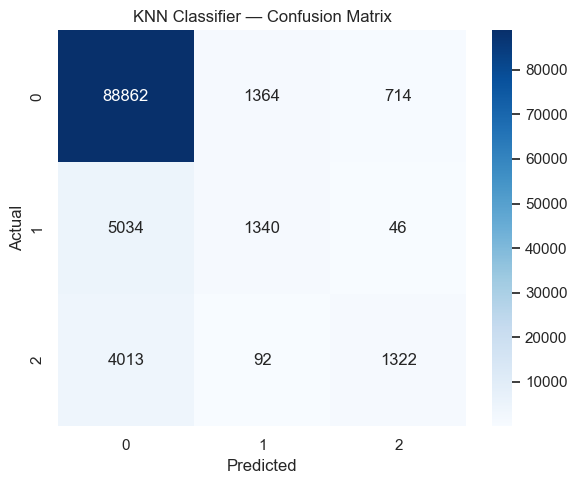

Multiclass ROC AUC (OvR, weighted): 0.7132


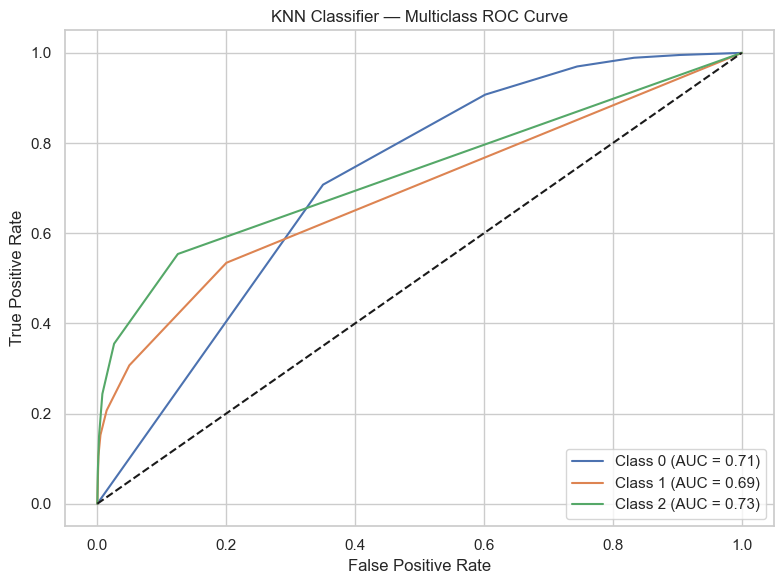


Support Vector Classifier
-------------------------
Accuracy (CV): 0.8941
Precision: 0.8756
Recall:    0.8941
F1 Score:  0.8606

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     90940
         1.0       0.71      0.15      0.25      6420
         2.0       0.69      0.12      0.20      5427

    accuracy                           0.89    102787
   macro avg       0.77      0.42      0.46    102787
weighted avg       0.88      0.89      0.86    102787



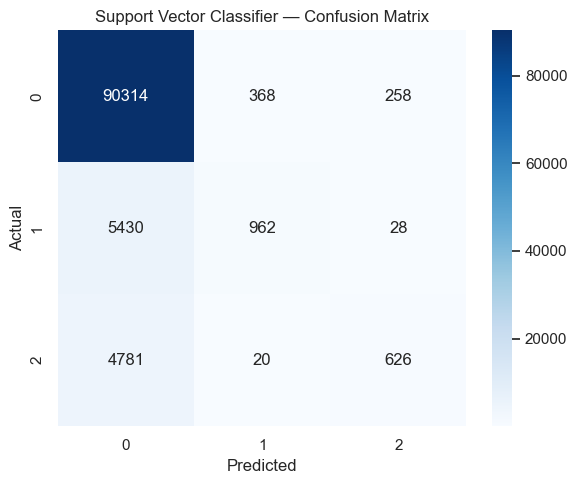

Multiclass ROC AUC (OvR, weighted): 0.7252


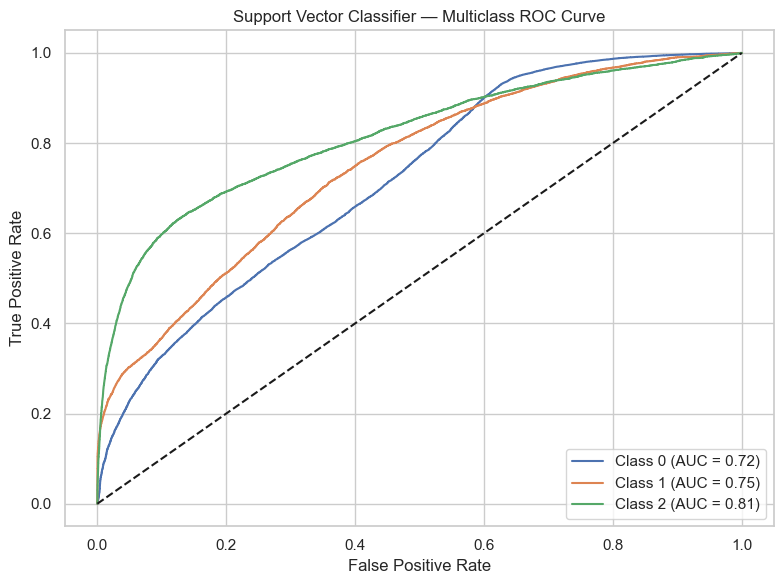

In [24]:
classifiers = [
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (KNeighborsClassifier(), "KNN Classifier"),
    (SVC(probability=True), "Support Vector Classifier")
]

for model, name in classifiers:
    evaluate_pipeline(model, name, X, y, feature_names=X.columns)
